## Create Initial states

In [9]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.mixture import MixtureDegModel
from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [10]:
data_name = "DS03"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [11]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [12]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [13]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [14]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [15]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

pf_models: dict[str,ParticleFilterModel]= {}
for name, units_perform in performs_train.items():
    models = []
    for unit, perform in units_perform.items():
        best_model = NModel()
        best_model.load_state_dict(
			torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
        best_model.to(device)
        best_model.eval()
        models.append(best_model)
    
    pf_models[name]=ParticleFilterModel(base_models=models,
                        net=ParticleFilterMLP(state_dim=5,hidden_dims=[3, 16]),
                        max_life = 100.0,
                        multiply_scale=0.05,
                        n_particles=90,
                        name = name).to(device)
    
    

## Mixture pdf 

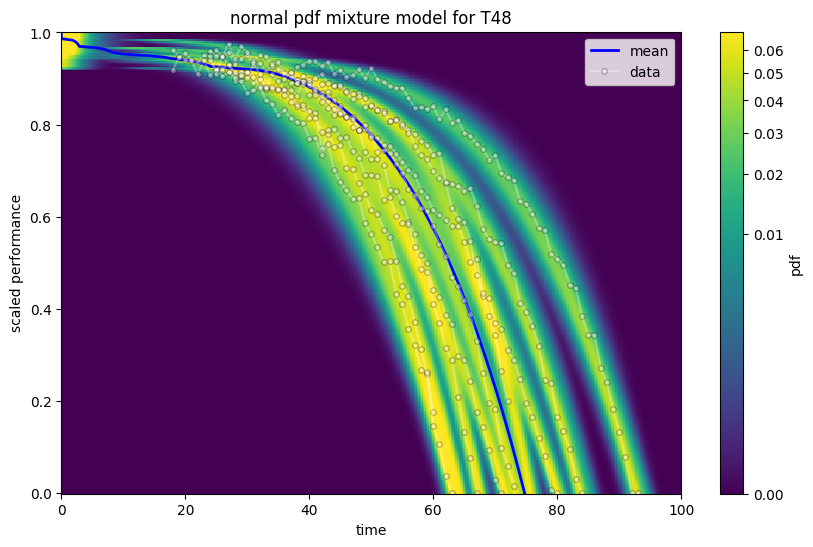

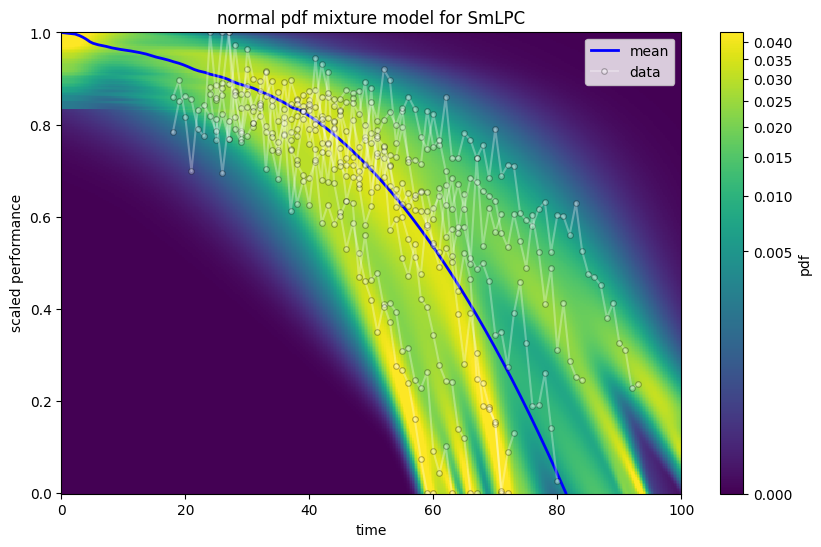

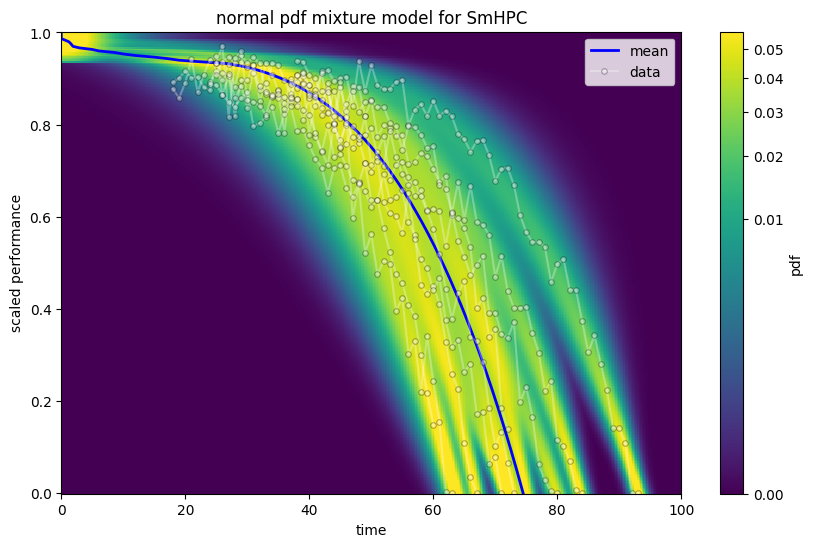

In [16]:
mixes: dict[str,MixtureDegModel]= {}
for name, pf_model in pf_models.items():
    ## Plot mix model
    mix_model = pf_model.mixture
    ax=mix_model.plot_distribution(t, s, 
                    func="pdf",
					title=f"normal pdf mixture model for {name}",
					plot_mean=True,
		)
    
    # Plot data
    first = True
    for unit,s_data in performs_train[name].items():
        t_data = time_train[unit]
        ax.plot(t_data,s_data,'o-',
				color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
				label='data' if first else None)
        first = False
    
    # adjust and plot
    ax.set_xlim([0, t.max()])
    ax.legend()
    plt.show()